In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np 
import pandas as pd 


In [ ]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/new')
zip_ref.close()

--2022-01-25 03:44:10--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.33.136.128, 2600:1403:15:28e::e59, 2600:1403:15:2ad::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.33.136.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   199MB/s    in 4.0s    

2022-01-25 03:44:14 (197 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [ ]:
cats = os.listdir('new/PetImages/Cat/')
dogs = os.listdir('new/PetImages/Dog/')


In [ ]:
REBUILD_DATA = True
class DogsVsCats():
  IMG_SIZE = 50 
  CATS = 'new/PetImages/Cat'
  DOGS = 'new/PetImages/Dog'
  labels = {CATS:0,DOGS:1}
  training_data = []
  cat_count = 0 
  dog_count = 0
  

  def make_training_data(self):
    for label in self.labels:
      print(label)
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label,f)
          img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
          img = cv2.resize(img,(self.IMG_SIZE,self.IMG_SIZE ))
          self.training_data.append([np.array(img),np.eye(2)[self.labels[label]]])
          if label == self.CATS:
            self.cat_count +=1
          elif label == self.DOGS:
            self.dog_count +=1  
        except Exception as e:
          pass
    np.random.shuffle(self.training_data)
    np.save('training_data.npy',self.training_data)
    print('cats: ',self.cat_count)
    print('dogs: ',self.dog_count)

if REBUILD_DATA:
  dogvcats  = DogsVsCats()
  dogvcats.make_training_data()

new/PetImages/Cat


100%|██████████| 12501/12501 [00:15<00:00, 807.09it/s]


new/PetImages/Dog


100%|██████████| 12501/12501 [00:16<00:00, 744.53it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


cats:  12476
dogs:  12470


In [ ]:
training_data = np.load('training_data.npy',allow_pickle=True)

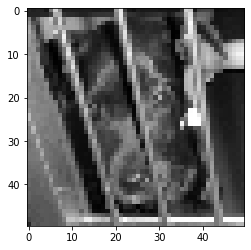

In [ ]:
plt.imshow(training_data[2][0],cmap='gray')

# starting the training


In [ ]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
 
 

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1  = nn.Conv2d(1,32,5)
    self.conv2  = nn.Conv2d(32,64,5)
    self.conv3  = nn.Conv2d(64,128,5)
    x = torch.randn(50,50).view(-1,1,50,50)
    self._to_linear  = None
    self.convs(x)


    self.fc1 = nn.Linear(self._to_linear,512)
    self.fc2 = nn.Linear(512,2)

  def convs(self,x):
    x = F.max_pool2d(F.relu(self.conv1(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)),(2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)),(2,2))
    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x
  

  def forward(self,x):
    x = self.convs(x)
    x = x.view(-1,self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x,dim=1)


net = Net()

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(),lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])
Val_pct = 0.1
Val_size = int(len(X)*Val_pct)

In [ ]:
train_X = X[:-Val_size]
train_y = y[:-Val_size]

test_X = X[-Val_size:]
test_y = y[-Val_size:]

In [31]:
batch_size = 100

epochs=5
for epoch in range(epochs):
  for i in tqdm(range(0,len(train_X),batch_size)):
    batch_x = train_X[i:i+batch_size].view(-1,1,50,50)
    batch_y = train_y[i:i+batch_size]


    net.zero_grad()
    outputs = net(batch_x)
    loss = loss_function(outputs,batch_y)
    loss.backward()
    optimizer.step()
print(loss)



100%|██████████| 225/225 [02:03<00:00,  1.82it/s]

100%|██████████| 225/225 [01:56<00:00,  1.93it/s]

100%|██████████| 225/225 [01:57<00:00,  1.91it/s]

100%|██████████| 225/225 [02:03<00:00,  1.82it/s]

100%|██████████| 225/225 [01:58<00:00,  1.90it/s]

tensor(0.0491, grad_fn=<MseLossBackward0>)


In [30]:
correct = 0
total = 0 
with torch.no_grad():
  for i in tqdm(range(len(test_X))):
    real_class = torch.argmax(test_y[i])
    net_out = net(test_X[i].view(-1,1,50,50))[0]
    predicted_class = torch.argmax(net_out)
    if predicted_class == real_class:
      correct+=1
    total+=1
print('accuracy:',round(correct/total,3))


100%|██████████| 2494/2494 [00:07<00:00, 337.79it/s]

accuracy: 0.768
